In [3]:
import shutil
from pathlib import Path

data_path = "./data/"

In [4]:
# imports for the notebook
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import pickle
import warnings
warnings.filterwarnings("ignore")


## Loading the dataset

In [5]:
# load the dataset
individual_data_frames = []

files_count = range(4)
for i in files_count:
  file_path = data_path + 'UNSW-NB15_'+str(i+1)+'.csv'
  individual_data_frames.append(pd.read_csv(file_path,header=None))

combined_dfs = pd.concat(individual_data_frames).reset_index(drop=True)

In [6]:
# load the feature names
features = pd.read_csv(data_path +'/NUSW-NB15_features.csv',encoding="latin-1")

In [7]:
# change the feature names to lowercase and remove blank characters
features['Name'] = features['Name'].apply(lambda x: x.lower().strip().replace(' ', ''))

In [8]:
# Columns to be used for transforming test data
saved_columns = features['Name'][features['Name']!='label'].tolist()

In [9]:
combined_dfs.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


In [10]:
# rename the column names to feature names 
combined_dfs.columns = features['Name']

combined_dfs.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


In [11]:
# split the data into train and test sets
from sklearn.model_selection import train_test_split

train, test = train_test_split(combined_dfs, test_size=0.35, random_state=7)

In [12]:
print(train.shape)
print(test.shape)
print("test")

(1651030, 49)
(889017, 49)
test


## Cleaning the data

In [13]:
# check the dataset for null values
train.isnull().sum()

Name
srcip                     0
sport                     0
dstip                     0
dsport                    0
proto                     0
state                     0
dur                       0
sbytes                    0
dbytes                    0
sttl                      0
dttl                      0
sloss                     0
dloss                     0
service                   0
sload                     0
dload                     0
spkts                     0
dpkts                     0
swin                      0
dwin                      0
stcpb                     0
dtcpb                     0
smeansz                   0
dmeansz                   0
trans_depth               0
res_bdy_len               0
sjit                      0
djit                      0
stime                     0
ltime                     0
sintpkt                   0
dintpkt                   0
tcprtt                    0
synack                    0
ackdat                    0
is_sm_ips_ports

In [14]:
# no. of null values in ct_flw_http_mthd
train['ct_flw_http_mthd'].isnull().sum()

876169

In [15]:
train['ct_flw_http_mthd'] = train.ct_flw_http_mthd.fillna(value=0)

In [16]:
# no. of null values in ct_flw_http_mthd
train['ct_flw_http_mthd'].isnull().sum()

0

In [17]:
# no. of null values in is_ftp_login
train['is_ftp_login'].isnull().sum()

929327

In [18]:
train['is_ftp_login'] = train.is_ftp_login.fillna(value=0)

In [19]:
# no. of null values in is_ftp_login
train['is_ftp_login'].isnull().sum()

0

In [20]:
# no. of null values in attack_cat
train['attack_cat'].isnull().sum()

1442045

In [21]:
# attack category should be N/A for entries with null values
train['attack_cat'] = train.attack_cat.fillna(value='n/a').apply(lambda x: x.strip().lower())

In [22]:
# no. of null values in attack_cat
train['attack_cat'].isnull().sum()

0

In [23]:
train.select_dtypes(include=object).columns

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'service',
       'ct_ftp_cmd', 'attack_cat'],
      dtype='object', name='Name')

In [24]:
train['srcip'].unique()

array(['59.166.0.6', '175.45.176.1', '59.166.0.7', '59.166.0.0',
       '149.171.126.18', '59.166.0.9', '59.166.0.5', '59.166.0.8',
       '59.166.0.4', '149.171.126.14', '59.166.0.2', '59.166.0.1',
       '175.45.176.3', '59.166.0.3', '149.171.126.15', '175.45.176.2',
       '175.45.176.0', '10.40.182.3', '149.171.126.10', '10.40.85.30',
       '10.40.85.1', '149.171.126.12', '10.40.85.10', '10.40.182.1',
       '10.40.170.2', '10.40.182.6', '149.171.126.5', '149.171.126.7',
       '149.171.126.6', '149.171.126.9', '149.171.126.2', '149.171.126.4',
       '149.171.126.13', '149.171.126.1', '149.171.126.3',
       '149.171.126.8', '192.168.241.243', '149.171.126.0',
       '149.171.126.16', '149.171.126.19', '149.171.126.17',
       '149.171.126.11', '127.0.0.1'], dtype=object)

In [25]:
train['sport'].unique()

# source port - sport should be a numerical value 
# convert all the non numerical values to numerical values

array([36300, 57700, 36667, ..., '18838', '30850', '22738'], dtype=object)

In [26]:
value_types = {}
for name, values in train.iteritems():
  if name == 'sport':
    for val in values:
      if type(val) not in value_types:
        value_types[type(val)] = 1
      else:
        value_types[type(val)] += 1

print(value_types)

# check how many string values can be converted to numbers
str_to_int = 0
for name, values in train.iteritems():
  if name == 'sport':
    for val in values:
      if isinstance(val, str):
        try:
          int(val)
          str_to_int += 1
        except ValueError:
          print("Cannot convert "+val+" to int.")

print("Can convert "+str(str_to_int)+" strings to int.")

# clean values
# convert hex values to decimal values
train['sport'] = train['sport'].apply(lambda x:int(x,16) if isinstance(x, str) and x.startswith('0x') else x)
# remove hyphen
train['sport'] = train['sport'].apply(lambda x:0 if x=="-" else x)
# convert strings to int
train['sport'] = train['sport'].apply(lambda x:int(x) if isinstance(x, str) else x)

train['sport'].unique()



{<class 'int'>: 1608197, <class 'str'>: 42833}
Cannot convert - to int.
Cannot convert 0x000c to int.
Cannot convert 0x000c to int.
Cannot convert 0x000c to int.
Cannot convert 0x000b to int.
Cannot convert 0x000b to int.
Can convert 42827 strings to int.


array([36300, 57700, 36667, ...,   356,   297,   225])

In [27]:
train['dstip'].unique()

array(['149.171.126.5', '149.171.126.13', '149.171.126.7',
       '149.171.126.4', '175.45.176.3', '149.171.126.8', '149.171.126.1',
       '149.171.126.9', '149.171.126.6', '149.171.126.17', '175.45.176.1',
       '149.171.126.0', '149.171.126.19', '149.171.126.10',
       '149.171.126.2', '149.171.126.14', '149.171.126.3',
       '149.171.126.15', '149.171.126.11', '149.171.126.18',
       '149.171.126.16', '10.40.182.3', '175.45.176.0', '10.40.85.1',
       '10.40.85.30', '149.171.126.12', '10.40.198.10', '224.0.0.5',
       '10.40.170.2', '192.168.241.50', '10.40.182.255', '59.166.0.6',
       '59.166.0.3', '59.166.0.2', '175.45.176.2', '59.166.0.0',
       '59.166.0.1', '59.166.0.4', '224.0.0.1', '59.166.0.5',
       '59.166.0.8', '192.168.241.243', '59.166.0.7', '59.166.0.9',
       '32.50.32.66', '10.40.182.6', '127.0.0.1'], dtype=object)

In [28]:
train['dsport'].unique()

array(['53', '80', 6881, ..., '62839', '62266', 60035], dtype=object)

In [29]:
train['proto'].unique()

array(['udp', 'tcp', 'unas', 'swipe', 'pim', 'ospf', 'arp', 'sctp',
       'mfe-nsp', 'pipe', 'ipip', 'vmtp', 'icmp', 'dcn', 'fc', 'sps',
       'snp', 'sep', 'gre', 'uti', 'st2', 'narp', 'compaq-peer', 'sun-nd',
       'ggp', 'egp', 'iatp', 'br-sat-mon', 'zero', 'bna', 'eigrp', 'idpr',
       'ddp', 'vines', 'pri-enc', 'any', 'qnx', 'ipnip', 'gmtp', 'skip',
       'srp', 'sat-expak', 'ipcv', 'iso-tp4', 'ippc', 'vrrp', 'crtp',
       'smp', 'xtp', 'cphb', 'prm', 'ip', 'isis', 'mux', 'etherip',
       'aris', 'ttp', 'ipv6-opts', 'wb-expak', 'ib', 'wsn', 'ipv6-route',
       'igmp', 'ipv6', 'ax.25', 'argus', 'leaf-2', 'tlsp', 'cbt', 'irtp',
       'ipx-n-ip', 'nvp', 'bbn-rcc', 'idrp', 'secure-vmtp', 'tcf', 'dgp',
       'idpr-cmtp', 'pvp', 'emcon', 'xns-idp', 'netblt', 'xnet',
       'aes-sp3-d', 'visa', 'iplt', 'ipcomp', 'merit-inp', 'rsvp', 'cftp',
       'trunk-1', 'l2tp', 'mhrp', 'pgm', 'encap', 'leaf-1', 'larp',
       'scps', 'igp', 'sccopmce', 'micp', 'ipv6-frag', 'a/n', 'ipv6-no'

In [30]:
train['state'].unique()

array(['CON', 'FIN', 'INT', 'REQ', 'ECO', 'PAR', 'RST', 'CLO', 'URH',
       'ACC', 'TST', 'ECR', 'URN', 'no', 'TXD', 'MAS'], dtype=object)

In [31]:
train['service'].unique()

# Here we need to replace '-' with none

array(['dns', 'http', '-', 'ftp-data', 'smtp', 'ssh', 'ftp', 'dhcp',
       'irc', 'pop3', 'ssl', 'snmp', 'radius'], dtype=object)

In [32]:
train['service'] = train['service'].apply(lambda x:'none' if x=='-' else x)

# cleaned data
train['service'].unique()

array(['dns', 'http', 'none', 'ftp-data', 'smtp', 'ssh', 'ftp', 'dhcp',
       'irc', 'pop3', 'ssl', 'snmp', 'radius'], dtype=object)

In [33]:
train['ct_ftp_cmd'].unique()

# Here we need to replace blank values with zero and convert string keys to numerical keys

array([' ', 0, '0', '1', 1, 3, 2, 6, '4', 4, 5, '2', 8], dtype=object)

In [34]:
train['ct_ftp_cmd'] = train['ct_ftp_cmd'].replace(" ",0).astype(int)

# cleaned data
train['ct_ftp_cmd'].unique()


array([0, 1, 3, 2, 6, 4, 5, 8])

In [35]:
train['attack_cat'].unique()

array(['n/a', 'exploits', 'dos', 'generic', 'reconnaissance', 'fuzzers',
       'analysis', 'backdoor', 'shellcode', 'backdoors', 'worms'],
      dtype=object)

In [36]:
# clean binary columns

train['is_sm_ips_ports'].value_counts()

0    1648321
1       2709
Name: is_sm_ips_ports, dtype: int64

In [37]:
train['is_ftp_login'].value_counts()

# make values greater than 1 as 1

0.0    1622782
1.0      28123
4.0        107
2.0         18
Name: is_ftp_login, dtype: int64

In [38]:
train['is_ftp_login'] = train['is_ftp_login'].apply(lambda x:1 if x>1 else x)

train['is_ftp_login'].value_counts()

0.0    1622782
1.0      28248
Name: is_ftp_login, dtype: int64

## Finding correlated features

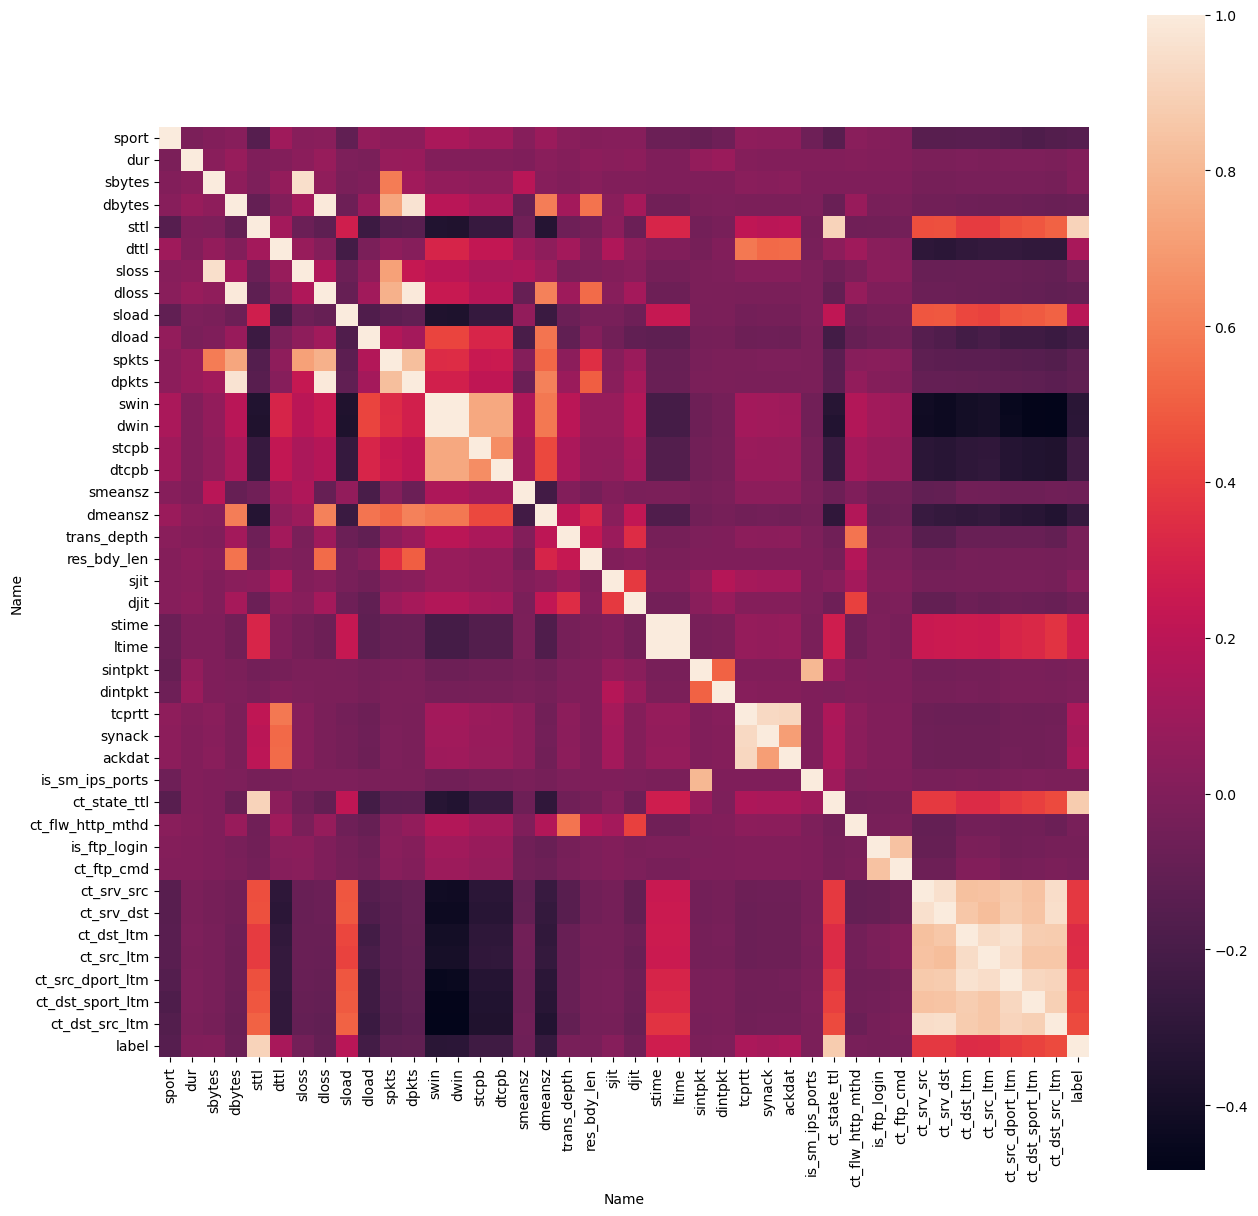

In [39]:
correlation_matrix = train.corr()

plt.figure(figsize=(15,15)) 
sns.heatmap(correlation_matrix, square=True)
plt.show()

In [40]:
# find features with correlation more than 0.9
no_of_rows = correlation_matrix.shape[0]
column_names = correlation_matrix.columns
no_of_correlated_features = 0
limits = [0.8,0.85,0.9]

for k in limits:
  no_of_correlated_features = 0
  for i in range(0,no_of_rows):
    for j in range(i+1,no_of_rows):
      if correlation_matrix.iloc[i,j]>=k:
        no_of_correlated_features += 1
        print(column_names[i]+", "+column_names[j]+" - "+str(correlation_matrix.iloc[i,j]))

  print("\nNo. of correlated features for limit "+str(k)+": "+str(no_of_correlated_features)+"\n")
  print("==========================================================")

sbytes, sloss - 0.9515011839850035
dbytes, dloss - 0.9912598569613217
dbytes, dpkts - 0.9705672906085007
sttl, ct_state_ttl - 0.9063315658872481
sttl, label - 0.9046505263282894
dloss, dpkts - 0.9921772489440207
spkts, dpkts - 0.8302375789700961
swin, dwin - 0.9972327727734585
stime, ltime - 0.9999999997741433
sintpkt, is_sm_ips_ports - 0.8016100445355301
tcprtt, synack - 0.9293375158809489
tcprtt, ackdat - 0.9191587355165262
ct_state_ttl, label - 0.8741014001431718
is_ftp_login, ct_ftp_cmd - 0.8408737319817609
ct_srv_src, ct_srv_dst - 0.9567468289854977
ct_srv_src, ct_dst_ltm - 0.8366001799886017
ct_srv_src, ct_src_ltm - 0.8405885995614935
ct_srv_src, ct_src_dport_ltm - 0.8697720596898506
ct_srv_src, ct_dst_sport_ltm - 0.8406181738772422
ct_srv_src, ct_dst_src_ltm - 0.9421667875831303
ct_srv_dst, ct_dst_ltm - 0.8598943087168189
ct_srv_dst, ct_src_ltm - 0.8246466745742577
ct_srv_dst, ct_src_dport_ltm - 0.8760386685786502
ct_srv_dst, ct_dst_sport_ltm - 0.84896220019858
ct_srv_dst, ct_ds

# Feature Engineering

In [42]:
# Correlation functions

# Func returns correlation between 2 given features
def corr(feature1, feature2="label", df=train):
    return df[[feature1, feature2]].corr().iloc[0,1]

# Func returns correlation between 2 given features
# Also gives corr with "label" after applying log1p.
def calc_multi_corr(feature1, feature2="label", df=train):
    corr = df[[feature1, feature2]].corr().iloc[0,1]
    log_corr = df[feature1].apply(np.log1p).corr(df[feature2])

    print("Correlation : {}\nlog_Correlation: {}".format(corr, log_corr))

In [43]:
binary_cols = ['is_sm_ips_ports', 'is_ftp_login']

## Find and remove highly correlated features

In [44]:
# Selecting features with high correlation values with other features
corr_matrix = train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# feature columns with correlation > 0.85
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
to_drop.remove('label')
print(to_drop)

['sloss', 'dloss', 'dpkts', 'dwin', 'ltime', 'synack', 'ackdat', 'ct_state_ttl', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm']


In [45]:
train.shape

(1651030, 49)

In [46]:
corr_col = to_drop 

# drop columns from train data
train.drop(columns=to_drop, inplace=True)

In [47]:
train.shape, test.shape

((1651030, 35), (889017, 49))

## Adding/Removing Features

* Network bytes: total number of bytes transmitted by a network, which is calculated as the sum of source-to-destination bytes (sbytes) and destination-to-source bytes (dbytes).

In [48]:
# creating new features
train['network_bytes'] = train['sbytes'] + train['dbytes']

In [49]:
# Removing columns that don't contribute to the classification. 
# The column "attack_cat" is intended for multiclass classification
# remaining columns are related to addresses and are not included in the sample training data.
train.drop(['srcip', 'sport', 'dstip', 'dsport', 'attack_cat'], axis=1, inplace=True)

In [50]:
# To use during test data transformation
saved_to_drop = ['srcip', 'sport', 'dstip', 'dsport', 'attack_cat']

In [51]:
train.shape, test.shape

((1651030, 31), (889017, 49))

## Applying log1p on Numerical columns

In [52]:
col_unique_values = train.nunique()
col = col_unique_values[col_unique_values>200].index

In [53]:
# calculating corr value of original col and after applying log1p on col
for column in col:
    print("{:-^30}".format(column))
    calc_multi_corr(column)

-------------dur--------------
Correlation : 0.001400089030408201
log_Correlation: -0.03317499966389567
------------sbytes------------
Correlation : 0.00918539704858462
log_Correlation: -0.3564366313322448
------------dbytes------------
Correlation : -0.07675593754735742
log_Correlation: -0.5194306152760445
------------sload-------------
Correlation : 0.19252471432025492
log_Correlation: 0.3469409866056079
------------dload-------------
Correlation : -0.21980438367654795
log_Correlation: -0.6031542587079646
------------spkts-------------
Correlation : -0.12299270995803764
log_Correlation: -0.3166395684484875
------------stcpb-------------
Correlation : -0.2335691255890391
log_Correlation: -0.3133156622132289
------------dtcpb-------------
Correlation : -0.2335355688471651
log_Correlation: -0.3131800173603627
-----------smeansz------------
Correlation : -0.0649708553344974
log_Correlation: -0.15102367896351632
-----------dmeansz------------
Correlation : -0.2726267259777533
log_Correlat

In [54]:
# Only applying log1p to these cols, dropping the original
log1p_col = ['dur', 'sbytes', 'dbytes', 'sload', 'dload', 'spkts', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'sjit', 'djit', 'network_bytes']

In [55]:
def log1p_transform(col, df=train):
    new_col = col+'_log1p'
    df[new_col] = df[col].apply(np.log1p)
    df.drop(col, axis=1, inplace=True)

In [56]:
# Transforming columns with log1p
for col in log1p_col:
    log1p_transform(col, df=train)

In [57]:
train.shape

(1651030, 31)

In [58]:
train.columns

Index(['proto', 'state', 'sttl', 'dttl', 'service', 'swin', 'trans_depth',
       'res_bdy_len', 'stime', 'sintpkt', 'dintpkt', 'tcprtt',
       'is_sm_ips_ports', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd',
       'ct_srv_src', 'label', 'dur_log1p', 'sbytes_log1p', 'dbytes_log1p',
       'sload_log1p', 'dload_log1p', 'spkts_log1p', 'stcpb_log1p',
       'dtcpb_log1p', 'smeansz_log1p', 'dmeansz_log1p', 'sjit_log1p',
       'djit_log1p', 'network_bytes_log1p'],
      dtype='object', name='Name')

In [59]:
# calculating mode values for every column
mode_values = train.mode().iloc[0].to_dict()

In [60]:
# dividing the data into x and y set
x_train, y_train = train.drop(columns=['label']), train['label']
x_test, y_test = test.drop(columns=['label']), test['label']

In [61]:
print(x_train.shape, y_train.shape)
print()
print(x_test.shape, y_test.shape)

(1651030, 30) (1651030,)

(889017, 48) (889017,)


In [62]:
# creating lists of categorical and numerical columns
cat_col = ['proto', 'service', 'state']
num_col = list(set(x_train.columns) - set(cat_col))

In [63]:
num_col

['trans_depth',
 'ct_srv_src',
 'dttl',
 'ct_flw_http_mthd',
 'res_bdy_len',
 'is_sm_ips_ports',
 'dintpkt',
 'swin',
 'sjit_log1p',
 'djit_log1p',
 'network_bytes_log1p',
 'is_ftp_login',
 'spkts_log1p',
 'sbytes_log1p',
 'dbytes_log1p',
 'smeansz_log1p',
 'sintpkt',
 'dtcpb_log1p',
 'dload_log1p',
 'stcpb_log1p',
 'tcprtt',
 'stime',
 'ct_ftp_cmd',
 'dur_log1p',
 'sload_log1p',
 'dmeansz_log1p',
 'sttl']

In [64]:
saved_num_col = num_col

In [65]:
saved_num_col

['trans_depth',
 'ct_srv_src',
 'dttl',
 'ct_flw_http_mthd',
 'res_bdy_len',
 'is_sm_ips_ports',
 'dintpkt',
 'swin',
 'sjit_log1p',
 'djit_log1p',
 'network_bytes_log1p',
 'is_ftp_login',
 'spkts_log1p',
 'sbytes_log1p',
 'dbytes_log1p',
 'smeansz_log1p',
 'sintpkt',
 'dtcpb_log1p',
 'dload_log1p',
 'stcpb_log1p',
 'tcprtt',
 'stime',
 'ct_ftp_cmd',
 'dur_log1p',
 'sload_log1p',
 'dmeansz_log1p',
 'sttl']

In [66]:
x_train.head()

Name,proto,state,sttl,dttl,service,swin,trans_depth,res_bdy_len,stime,sintpkt,...,sload_log1p,dload_log1p,spkts_log1p,stcpb_log1p,dtcpb_log1p,smeansz_log1p,dmeansz_log1p,sjit_log1p,djit_log1p,network_bytes_log1p
2402763,udp,CON,31,29,dns,0,0,0,1424258903,0.008000,...,13.138847,13.358908,1.098612,0.000000,0.000000,4.189655,4.406719,0.000000,0.000000,5.680173
1262231,tcp,FIN,62,252,http,255,1,180,1424226630,29.977089,...,10.253662,12.007948,2.564949,20.295228,21.812898,4.672829,6.255750,7.288759,7.451177,9.054739
1063079,tcp,FIN,31,29,none,255,0,0,1421971627,24.096564,...,9.825161,13.624639,6.493754,21.994653,22.001274,4.043051,7.158514,9.258080,8.925890,14.333186
291332,udp,CON,31,29,dns,0,0,0,1421939146,0.013000,...,13.062632,13.279697,1.098612,0.000000,0.000000,4.204693,4.418841,0.000000,0.000000,5.693732
1374804,udp,INT,60,0,dns,0,0,0,1424230527,0.007000,...,18.831844,0.000000,1.098612,0.000000,0.000000,4.890349,0.000000,0.000000,0.000000,5.579730


## Standardizing the data
    

In [67]:
# Standardizing the data
scaler = StandardScaler()
scaler = scaler.fit(x_train[num_col])

In [68]:
x_train[num_col] = scaler.transform(x_train[num_col])

In [69]:
x_train.head()

Name,proto,state,sttl,dttl,service,swin,trans_depth,res_bdy_len,stime,sintpkt,...,sload_log1p,dload_log1p,spkts_log1p,stcpb_log1p,dtcpb_log1p,smeansz_log1p,dmeansz_log1p,sjit_log1p,djit_log1p,network_bytes_log1p
2402763,udp,CON,-0.426026,-0.041411,dns,-1.196659,-0.235102,-0.091645,0.879916,-0.069620,...,-0.154027,0.468717,-1.081480,-1.190677,-1.190384,-0.558268,0.055936,-0.995948,-0.900561,-1.019830
1262231,tcp,FIN,-0.010721,5.159522,http,0.835670,2.581900,-0.087771,0.851468,-0.058828,...,-1.072107,0.231171,-0.002652,0.750543,0.895945,0.216871,0.856019,1.258884,1.746486,0.423464
1063079,tcp,FIN,-0.426026,-0.041411,none,0.835670,-0.235102,-0.091645,-1.136265,-0.060946,...,-1.208458,0.515441,2.887885,0.913092,0.913962,-0.793458,1.246649,1.868109,2.270381,2.681044
291332,udp,CON,-0.426026,-0.041411,dns,-1.196659,-0.235102,-0.091645,-1.164897,-0.069618,...,-0.178279,0.454789,-1.081480,-1.190677,-1.190384,-0.534143,0.061181,-0.995948,-0.900561,-1.014030
1374804,udp,INT,-0.037515,-0.717766,dns,-1.196659,-0.235102,-0.091645,0.854903,-0.069620,...,1.657513,-1.880240,-1.081480,-1.190677,-1.190384,0.565830,-1.850870,-0.995948,-0.900561,-1.062789


## Converting Categorical Columns to Numerical using Onehot Encoding


In [70]:
# Onehot Encoding
service_ = OneHotEncoder()
proto_ = OneHotEncoder()
state_ = OneHotEncoder()
OneHE_service = service_.fit(x_train.service.values.reshape(-1,1))
OneHE_proto = proto_.fit(x_train.proto.values.reshape(-1,1))
OneHE_state = state_.fit(x_train.state.values.reshape(-1,1))

In [71]:
for col, OneHE in zip(['proto', 'service', 'state'], [OneHE_proto, OneHE_service, OneHE_state]):
    x = OneHE.transform(x_train[col].values.reshape(-1,1)).tocsr()
    tmp_df = pd.DataFrame(x.todense(), columns=[col+'_'+i for i in OneHE.categories_[0]])
    x_train = pd.concat([x_train.drop(col, axis=1), pd.get_dummies(x_train[col], prefix=col)], axis=1)


In [72]:
x_train.head()

,sttl,dttl,swin,trans_depth,res_bdy_len,stime,sintpkt,dintpkt,tcprtt,is_sm_ips_ports,...,state_INT,state_MAS,state_PAR,state_REQ,state_RST,state_TST,state_TXD,state_URH,state_URN,state_no
2402763,-0.426026,-0.041411,-1.196659,-0.235102,-0.091645,0.879916,-0.069620,-0.055142,-0.136516,-0.04054,...,0,0,0,0,0,0,0,0,0,0
1262231,-0.010721,5.159522,0.835670,2.581900,-0.087771,0.851468,-0.058828,-0.037997,1.015976,-0.04054,...,0,0,0,0,0,0,0,0,0,0
1063079,-0.426026,-0.041411,0.835670,-0.235102,-0.091645,-1.136265,-0.060946,-0.046559,-0.117213,-0.04054,...,0,0,0,0,0,0,0,0,0,0
291332,-0.426026,-0.041411,-1.196659,-0.235102,-0.091645,-1.164897,-0.069618,-0.055140,-0.136516,-0.04054,...,0,0,0,0,0,0,0,0,0,0
1374804,-0.037515,-0.717766,-1.196659,-0.235102,-0.091645,0.854903,-0.069620,-0.055147,-0.136516,-0.04054,...,1,0,0,0,0,0,0,0,0,0


## Pipeline functions

In [73]:
# Clean the data: remove Null, wrong calues, check for col datatype and fix them.
def clean_data(data):

    numerical_col = data.select_dtypes(include=np.number).columns 
    categorical_col = data.select_dtypes(exclude=np.number).columns 
    
    for col in data.columns:
        val = mode_values[col]  # Mode value of the column in train data
        data[col] = data[col].fillna(value=val) # replace Null values with mode value
        data[col] = data[col].replace(' ', value=val)
        data[col] = data[col].apply(lambda x:"none" if x=="-" else x)

        # Correcting binary columns
        if col in 'binary_col':
            data[col] = np.where(data[col]>1, val, data[col])

    # Correcting datatype of columns
    bad_dtypes = list(set(categorical_col) - set(cat_col))
    for bad_col in bad_dtypes:
        data[col] = data[col].astype(float)
    
    return data

In [74]:
# log1p function
def apply_log1p(data):
    for col in log1p_col:
        new_col = col + '_log1p' 
        data[new_col] = data[col].apply(np.log1p) 
        data.drop(col, axis=1, inplace=True) 
    return data

In [75]:
# Standarize the data
def standardize(data):
    data[num_col] = scaler.transform(data[num_col])
    return data

In [76]:
# OneHot Encoding the cat columns
def OneHEncoding(data):

    X1 = OneHE_service.transform(data['service'].values.reshape(-1, 1))
    X2 = OneHE_proto.transform(data['proto'].values.reshape(-1, 1))
    X3 = OneHE_state.transform(data['state'].values.reshape(-1, 1))
    
    data = pd.concat([data,
                      pd.DataFrame(X2.toarray(), columns=['proto_'+i for i in OneHE_proto.categories_[0]]),
                      pd.DataFrame(X1.toarray(), columns=['service_'+i for i in OneHE_service.categories_[0]]),
                      pd.DataFrame(X3.toarray(), columns=['state_'+i for i in OneHE_state.categories_[0]])],
                      axis=1)
    
    data.drop(['proto', 'service', 'state'], axis=1, inplace=True)

    return data

# Transforming Test Data

In [77]:
# Reset index
x_test.reset_index(drop=True, inplace=True)

In [78]:
x_test.shape

(889017, 48)

In [79]:
x_test.columns

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes',
       'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'sload', 'dload',
       'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime',
       'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat'],
      dtype='object', name='Name')

In [80]:
# Adding column names
x_test.columns = saved_columns

In [81]:
# Creating new Feature
x_test['network_bytes'] = x_test['dbytes'] + x_test['sbytes']

In [82]:
# Removing the columns that are not needed
dropable_col = saved_to_drop + corr_col
x_test.drop(columns=dropable_col, inplace=True)

In [83]:
x_test.columns

Index(['proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'service',
       'sload', 'dload', 'spkts', 'swin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime',
       'sintpkt', 'dintpkt', 'tcprtt', 'is_sm_ips_ports', 'ct_flw_http_mthd',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'network_bytes'],
      dtype='object')

In [84]:
x_test.shape

(889017, 30)

In [85]:
# apply log1p
x_test = apply_log1p(x_test)

In [86]:
# Clean the test data
x_test = clean_data(x_test)

In [87]:
x_test.shape

(889017, 30)

In [88]:
x_test.shape

(889017, 30)

In [89]:
x_test.columns

Index(['proto', 'state', 'sttl', 'dttl', 'service', 'swin', 'trans_depth',
       'res_bdy_len', 'stime', 'sintpkt', 'dintpkt', 'tcprtt',
       'is_sm_ips_ports', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd',
       'ct_srv_src', 'dur_log1p', 'sbytes_log1p', 'dbytes_log1p',
       'sload_log1p', 'dload_log1p', 'spkts_log1p', 'stcpb_log1p',
       'dtcpb_log1p', 'smeansz_log1p', 'dmeansz_log1p', 'sjit_log1p',
       'djit_log1p', 'network_bytes_log1p'],
      dtype='object')

In [90]:
# Standardize the data
x_test = standardize(x_test)

In [91]:
x_test.head()

,proto,state,sttl,dttl,service,swin,trans_depth,res_bdy_len,stime,sintpkt,...,sload_log1p,dload_log1p,spkts_log1p,stcpb_log1p,dtcpb_log1p,smeansz_log1p,dmeansz_log1p,sjit_log1p,djit_log1p,network_bytes_log1p
0,udp,CON,-0.426026,-0.041411,none,-1.196659,-0.235102,-0.091645,0.866760,-0.062785,...,-0.932593,-0.099913,-0.705650,-1.190677,-1.190384,0.589775,0.028713,0.033228,-0.036746,-0.568857
1,udp,INT,2.561488,-0.717766,dns,-1.196659,-0.235102,-0.091645,0.863466,-0.069621,...,1.568372,-1.880240,-1.081480,-1.190677,-1.190384,-0.765558,-1.850870,-0.995948,-0.900561,-1.419830
2,tcp,FIN,-0.426026,-0.041411,none,0.835670,-0.235102,-0.091645,0.849247,-0.069468,...,0.190731,0.757816,-0.002652,0.860323,0.928978,-0.115085,0.419539,-0.025006,-0.757188,0.015713
3,udp,INT,2.561488,-0.717766,none,-1.196659,-0.235102,-0.091645,0.868085,-0.069620,...,1.318596,-1.880240,-1.081480,-1.190677,-1.190384,-0.910184,-1.850870,-0.995948,-0.900561,-1.458738
4,tcp,FIN,-0.426026,-0.041411,none,0.835670,-0.235102,-0.091645,-1.160462,-0.069509,...,0.207038,0.992077,0.805629,0.883535,0.722571,-0.582761,0.819651,-0.071283,0.135441,0.818932


In [92]:
# OHE
x_test = OneHEncoding(x_test)

In [93]:
x_test.shape

(889017, 191)

In [94]:
# Final test data
x_test.head()

,sttl,dttl,swin,trans_depth,res_bdy_len,stime,sintpkt,dintpkt,tcprtt,is_sm_ips_ports,...,state_INT,state_MAS,state_PAR,state_REQ,state_RST,state_TST,state_TXD,state_URH,state_URN,state_no
0,-0.426026,-0.041411,-1.196659,-0.235102,-0.091645,0.866760,-0.062785,-0.050078,-0.136516,-0.04054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.561488,-0.717766,-1.196659,-0.235102,-0.091645,0.863466,-0.069621,-0.055147,-0.136516,-0.04054,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.426026,-0.041411,0.835670,-0.235102,-0.091645,0.849247,-0.069468,-0.054881,-0.115418,-0.04054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.561488,-0.717766,-1.196659,-0.235102,-0.091645,0.868085,-0.069620,-0.055147,-0.136516,-0.04054,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.426026,-0.041411,0.835670,-0.235102,-0.091645,-1.160462,-0.069509,-0.054944,-0.121114,-0.04054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
# Check if train and test data have same columns
all(x_train.columns == x_test.columns)

True

In [96]:
#To calculate the false alarm rate
def false_alarm_rate(y_true, y_pred):
  
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    FPR = fp / (fp + tn)  # False positive rate
    FNR = fn / (fn + tp)  # False negetive rate
    return (FPR+FNR)/2  # False alarm rate

In [97]:
from sklearn.linear_model import LogisticRegression, SGDClassifier 
from sklearn.svm import LinearSVC  
from sklearn.tree import DecisionTreeClassifier  
from sklearn.ensemble import RandomForestClassifier  

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer  
from sklearn.metrics import auc, f1_score, roc_curve, roc_auc_score  
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV  

%matplotlib inline

# Logistic Regression with L2 regularization

epoch: 0   ,    accuracy_score: 0.9873799991520444
epoch: 1   ,    accuracy_score: 0.9873921128023113
epoch: 2   ,    accuracy_score: 0.9872303955712495
epoch: 3   ,    accuracy_score: 0.9872134364608759
epoch: 4   ,    accuracy_score: 0.9874472299110253
epoch: 5   ,    accuracy_score: 0.9872661308395365
epoch: 6   ,    accuracy_score: 0.9873963525799047
epoch: 7   ,    accuracy_score: 0.9872909638225835
epoch: 8   ,    accuracy_score: 0.9873902957547712
epoch: 9   ,    accuracy_score: 0.9873279104558972


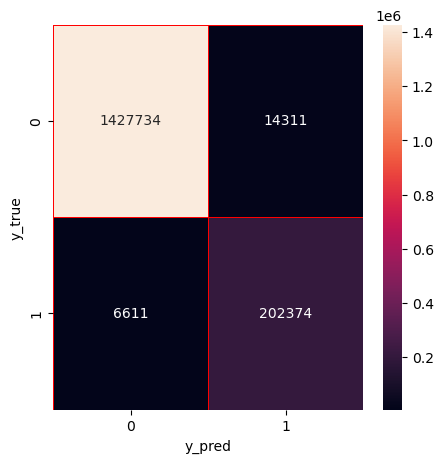

In [98]:
# Tuning "alpha" for l2 "penalty"
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
clf = SGDClassifier(loss='log', penalty='l2')
epochs = 10
for i in range(epochs):
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_train)
    acc_score = accuracy_score(y_pred, y_train)
    acc_score
    print("epoch: {}   ,    accuracy_score: {}".format(i,acc_score))

l2_train_precision,l2_train_recall,l2_train_fscore,none= precision_recall_fscore_support(y_train, y_pred, average='weighted') 

cm=confusion_matrix(y_train,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [99]:
print(classification_report(y_train,y_pred))
# An empty dictionary to store the result of all the models
result_dict_train = {"name":[], "auc":[], "f1":[], "recall":[]}

              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1442045
           1       0.93      0.97      0.95    208985

    accuracy                           0.99   1651030
   macro avg       0.96      0.98      0.97   1651030
weighted avg       0.99      0.99      0.99   1651030



In [100]:
result_dict_train['name'].append("LR with l2 penalty")
result_dict_train['auc'].append(l2_train_precision)
result_dict_train['f1'].append(l2_train_fscore)
result_dict_train['recall'].append(l2_train_recall)

In [101]:
result_dict_test = {"name":[], "auc":[], "f1":[], "recall":[]}

accuracy_score: 0.9873781941177727


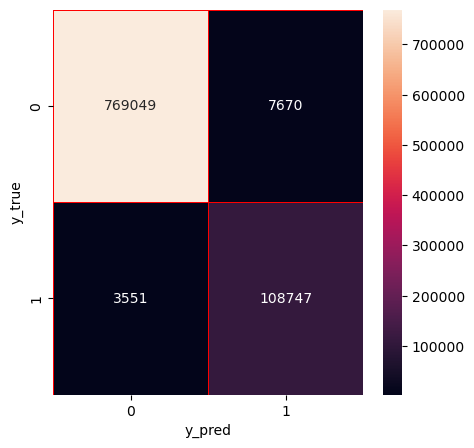

In [102]:
y_pred = clf.predict(x_test)
acc_score = accuracy_score(y_pred, y_test)
acc_score
print("accuracy_score: {}".format(acc_score))

l2_test_precision,l2_test_recall,l2_test_fscore,none= precision_recall_fscore_support(y_test, y_pred, average='weighted') 

cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [103]:
result_dict_test['name'].append("LR with l2 penalty")
result_dict_test['auc'].append(l2_test_precision)
result_dict_test['f1'].append(l2_test_fscore)
result_dict_test['recall'].append(l2_test_recall)

In [104]:
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       1.00      0.99      0.99    776719
           1       0.93      0.97      0.95    112298

    accuracy                           0.99    889017
   macro avg       0.96      0.98      0.97    889017
weighted avg       0.99      0.99      0.99    889017



# Logistic Regression with L2 regularization

epoch: 0   ,    accuracy_score: 0.9870632271975676
epoch: 1   ,    accuracy_score: 0.9878875610982235
epoch: 2   ,    accuracy_score: 0.9875889596191468
epoch: 3   ,    accuracy_score: 0.9871110761161215
epoch: 4   ,    accuracy_score: 0.9876967711065214
epoch: 5   ,    accuracy_score: 0.9875665493661533
epoch: 6   ,    accuracy_score: 0.9873006547427969
epoch: 7   ,    accuracy_score: 0.9865871607420822
epoch: 8   ,    accuracy_score: 0.9875544357158864
epoch: 9   ,    accuracy_score: 0.9874121003252515
Precision of SGD Classifier with l1 penality : 0.9873957880304887
Recall of SGD Classifier with l1 penality: 0.9874121003252515
F1-score of SGD Classifier with l1 penality: 0.9874035989912976


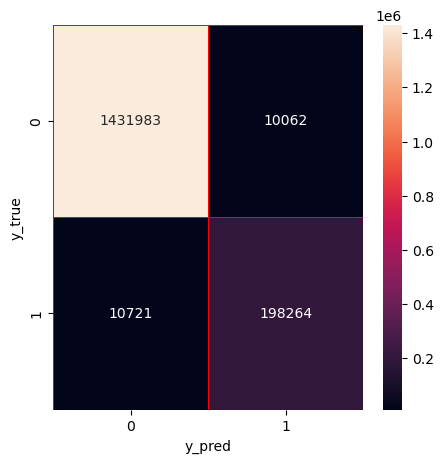

In [115]:
# Tuning "alpha" for l1 "penalty"
clf = SGDClassifier(loss='log', penalty='l1',early_stopping=True)
epochs = 10
for i in range(epochs):
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_train)
    acc_score = accuracy_score(y_pred, y_train)
    acc_score
    print("epoch: {}   ,    accuracy_score: {}".format(i,acc_score))

l1_train_precision,l1_train_recall,l1_train_fscore,none= precision_recall_fscore_support(y_train, y_pred, average='weighted') 
print('Precision of SGD Classifier with l1 penality : '+(str(l1_train_precision)))
print('Recall of SGD Classifier with l1 penality: '+(str(l1_train_recall)))
print('F1-score of SGD Classifier with l1 penality: '+(str(l1_train_fscore)))
cm=confusion_matrix(y_train,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()



In [116]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1442045
           1       0.95      0.95      0.95    208985

    accuracy                           0.99   1651030
   macro avg       0.97      0.97      0.97   1651030
weighted avg       0.99      0.99      0.99   1651030



In [117]:
result_dict_train['name'].append("Logistic Regression with l1 penalty")
result_dict_train['auc'].append(l1_train_precision)
result_dict_train['f1'].append(l1_train_fscore)
result_dict_train['recall'].append(l1_train_recall)

accuracy_score: 0.9873365751161114


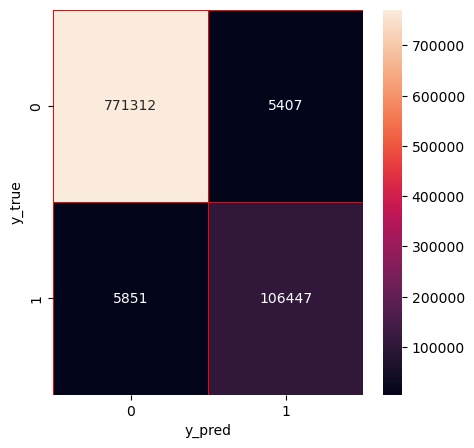

In [118]:
y_pred = clf.predict(x_test)
acc_score = accuracy_score(y_pred, y_test)
acc_score
print("accuracy_score: {}".format(acc_score))

l1_test_precision,l1_test_recall,l1_test_fscore,none= precision_recall_fscore_support(y_test, y_pred, average='weighted') 
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [119]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    776719
           1       0.95      0.95      0.95    112298

    accuracy                           0.99    889017
   macro avg       0.97      0.97      0.97    889017
weighted avg       0.99      0.99      0.99    889017



In [122]:
result_dict_test['name'].append("LR with l1 penalty")
result_dict_test['auc'].append(l1_test_precision)
result_dict_test['f1'].append(l1_test_fscore)
result_dict_test['recall'].append(l1_test_recall)

# Linear SVM

epoch: 0   ,    accuracy_score: 0.9874175514678716
epoch: 1   ,    accuracy_score: 0.9874223969279783
epoch: 2   ,    accuracy_score: 0.9874084662301714
epoch: 3   ,    accuracy_score: 0.9874096775951982
epoch: 4   ,    accuracy_score: 0.9873866616596912
epoch: 5   ,    accuracy_score: 0.9873751536919377
epoch: 6   ,    accuracy_score: 0.9874266367055716
epoch: 7   ,    accuracy_score: 0.9873478979788375
epoch: 8   ,    accuracy_score: 0.9873818161995845
epoch: 9   ,    accuracy_score: 0.9873660684542377


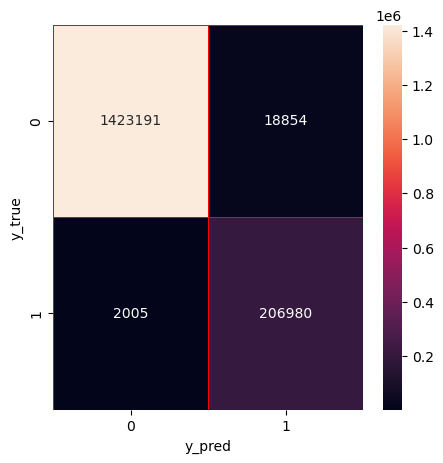

In [121]:
clf = SGDClassifier(loss='hinge')
for i in range(epochs):
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_train)
    acc_score = accuracy_score(y_pred, y_train)
    acc_score
    print("epoch: {}   ,    accuracy_score: {}".format(i,acc_score))

svm_train_precision,svm_train_recall,svm_train_fscore,none= precision_recall_fscore_support(y_train, y_pred, average='weighted') 

cm=confusion_matrix(y_train,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [123]:
print(classification_report(y_train,y_pred))


              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1442045
           1       0.92      0.99      0.95    208985

    accuracy                           0.99   1651030
   macro avg       0.96      0.99      0.97   1651030
weighted avg       0.99      0.99      0.99   1651030



In [124]:
result_dict_train['name'].append("SVM")
result_dict_train['auc'].append(svm_train_precision)
result_dict_train['f1'].append(svm_train_fscore)
result_dict_train['recall'].append(svm_train_recall)

accuracy_score: 0.9873860679829519


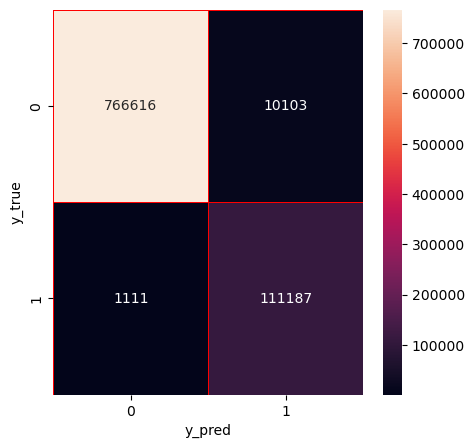

In [125]:
y_pred = clf.predict(x_test)
acc_score = accuracy_score(y_pred, y_test)
acc_score
print("accuracy_score: {}".format(acc_score))

svm_test_precision,svm_test_recall,svm_test_fscore,none= precision_recall_fscore_support(y_test, y_pred, average='weighted') 

cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [126]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    776719
           1       0.92      0.99      0.95    112298

    accuracy                           0.99    889017
   macro avg       0.96      0.99      0.97    889017
weighted avg       0.99      0.99      0.99    889017



In [127]:
result_dict_test['name'].append("SVM")
result_dict_test['auc'].append(svm_test_precision)
result_dict_test['f1'].append(svm_test_fscore)
result_dict_test['recall'].append(svm_test_recall)

# Decision Tree Classifier

epoch: 0   ,    accuracy_score: 0.9999618420016596
epoch: 1   ,    accuracy_score: 0.9999618420016596
epoch: 2   ,    accuracy_score: 0.9999618420016596
epoch: 3   ,    accuracy_score: 0.9999618420016596
epoch: 4   ,    accuracy_score: 0.9999618420016596
epoch: 5   ,    accuracy_score: 0.9999618420016596
epoch: 6   ,    accuracy_score: 0.9999618420016596
epoch: 7   ,    accuracy_score: 0.9999618420016596
epoch: 8   ,    accuracy_score: 0.9999618420016596
epoch: 9   ,    accuracy_score: 0.9999618420016596


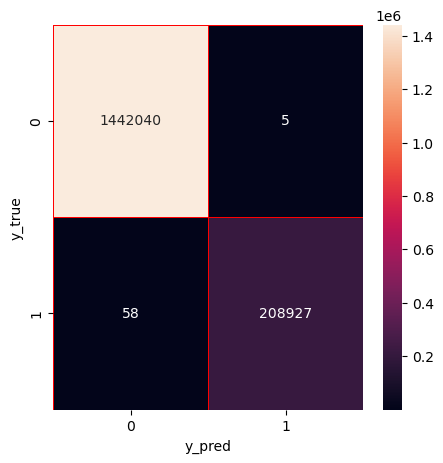

In [128]:
# DT classifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report


clf = DecisionTreeClassifier()
for i in range(10):
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_train)
    acc_score = accuracy_score(y_pred, y_train)
    acc_score
    print("epoch: {}   ,    accuracy_score: {}".format(i,acc_score))

dt_train_precision,dt_train_recall,dt_train_fscore,none= precision_recall_fscore_support(y_train, y_pred, average='weighted') 

cm=confusion_matrix(y_train,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [129]:
print(classification_report(y_train,y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1442045
           1       1.00      1.00      1.00    208985

    accuracy                           1.00   1651030
   macro avg       1.00      1.00      1.00   1651030
weighted avg       1.00      1.00      1.00   1651030



In [160]:
# Check the validation score
from sklearn.model_selection import learning_curve

train_sizes_abs, train_scores, valid_scores =  learning_curve(DecisionTreeClassifier(max_depth=2), x_train, y_train)

In [161]:
train_scores

array([[0.98210203, 0.98225345, 0.98225345, 0.98225345, 0.98225345],
       [0.98209739, 0.98212068, 0.98214631, 0.98214631, 0.98214631],
       [0.98217228, 0.98218467, 0.98218329, 0.98214888, 0.98214888],
       [0.98226912, 0.98227303, 0.98227694, 0.98222125, 0.98218609],
       [0.98238827, 0.9823913 , 0.98239432, 0.98234965, 0.98223609]])

In [162]:
valid_scores

array([[0.98220202, 0.98218082, 0.98218991, 0.98235041, 0.98281073],
       [0.98221413, 0.98218385, 0.98219293, 0.98232618, 0.9828077 ],
       [0.98219596, 0.98218385, 0.98217779, 0.98232618, 0.9828077 ],
       [0.98220202, 0.98218991, 0.98217779, 0.98232618, 0.9828077 ],
       [0.98220202, 0.98218991, 0.98217779, 0.98232618, 0.98281073]])

In [166]:
train_sizes_abs

array([ 132082,  429267,  726453, 1023638, 1320824])

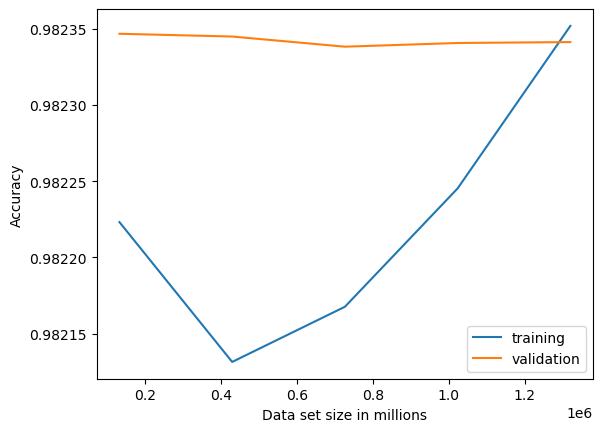

In [170]:
# plot validation chart

# plot_data_count = len(train_scores[0])
# plot_data = []
# for itr in range(plot_data_count):
#     plot_data.append([train_scores[0][itr],valid_scores[0][itr]])
    
# decision_trees_df = pd.DataFrame(plot_data,columns=['training','validation'])
# plot1 = decision_trees_df.plot()
# plot1.set_ylim(0.96,1.0)

# Check the validation score
from sklearn.model_selection import learning_curve

train_sizes_abs, train_scores, valid_scores =  learning_curve(DecisionTreeClassifier(max_depth=2), x_train, y_train)

plt.plot(train_sizes_abs,np.mean(train_scores,axis=1),label="training")
plt.plot(train_sizes_abs,np.mean(valid_scores,axis=1),label="validation")
plt.ylabel("Accuracy")
plt.xlabel("Data set size in millions")
plt.legend()

In [130]:
result_dict_train['name'].append("DT")
result_dict_train['auc'].append(dt_train_precision)
result_dict_train['f1'].append(dt_train_fscore)
result_dict_train['recall'].append(dt_train_recall)

accuracy_score: 0.9945681578642478


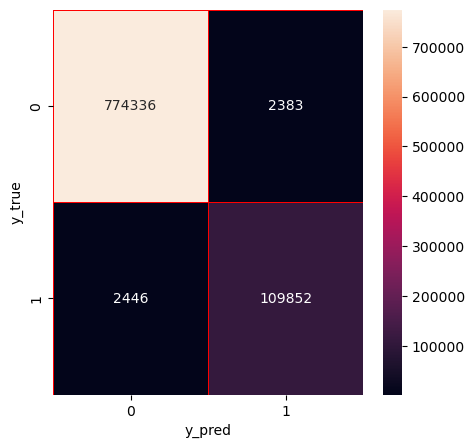

In [131]:
y_pred = clf.predict(x_test)
acc_score = accuracy_score(y_pred, y_test)
acc_score
print("accuracy_score: {}".format(acc_score))

dt_test_precision,dt_test_recall,dt_test_fscore,none= precision_recall_fscore_support(y_test, y_pred, average='weighted') 

cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [132]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    776719
           1       0.98      0.98      0.98    112298

    accuracy                           0.99    889017
   macro avg       0.99      0.99      0.99    889017
weighted avg       0.99      0.99      0.99    889017



In [133]:
result_dict_test['name'].append("DT")
result_dict_test['auc'].append(dt_test_precision)
result_dict_test['f1'].append(dt_test_fscore)
result_dict_test['recall'].append(dt_test_recall)

# Random Forest Classifier

epoch: 0   ,    accuracy_score: 0.9703482068769193
epoch: 1   ,    accuracy_score: 0.971154370302175
epoch: 2   ,    accuracy_score: 0.9704202830960067
epoch: 3   ,    accuracy_score: 0.9703700114473995
epoch: 4   ,    accuracy_score: 0.9705014445527943
epoch: 5   ,    accuracy_score: 0.9705038672828477
epoch: 6   ,    accuracy_score: 0.9709756939607397
epoch: 7   ,    accuracy_score: 0.9703863648752596
epoch: 8   ,    accuracy_score: 0.9694402887894223
epoch: 9   ,    accuracy_score: 0.9704426933490004


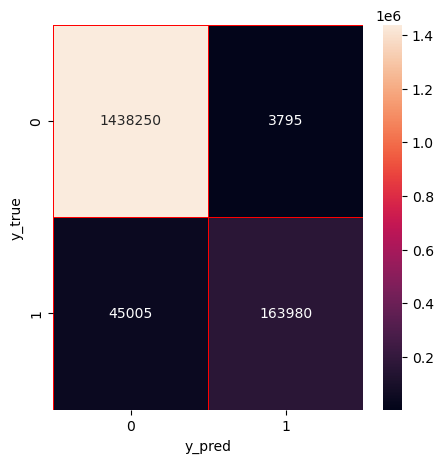

In [134]:
# Classifier Name
clf = RandomForestClassifier(max_depth=2)
for i in range(10):
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_train)
    acc_score = accuracy_score(y_pred, y_train)
    acc_score
    print("epoch: {}   ,    accuracy_score: {}".format(i,acc_score))

rf_train_precision,rf_train_recall,rf_train_fscore,none= precision_recall_fscore_support(y_train, y_pred, average='weighted') 

cm=confusion_matrix(y_train,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [135]:
print(classification_report)

<function classification_report at 0x12a6e4430>


In [138]:
rfcl = RandomForestClassifier(max_depth=2)
rfcl.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [171]:
result_dict_train['name'].append("RF")
result_dict_train['auc'].append(rf_train_precision)
result_dict_train['f1'].append(rf_train_fscore)
result_dict_train['recall'].append(rf_train_recall)

In [172]:
result_dict_train = pd.DataFrame.from_dict(result_dict_train)


accuracy_score: 0.9707609640760525
Precision of RF Classifier : 0.9709516214698038
Recall of RF Classifier : 0.9707609640760525
F1-score of RF Classifier : 0.9693801257124275


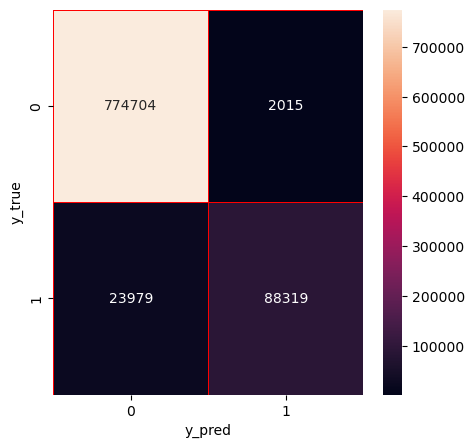

In [173]:
y_pred = clf.predict(x_test)
acc_score = accuracy_score(y_pred, y_test)
acc_score
print("accuracy_score: {}".format(acc_score))

rf_test_precision,rf_test_recall,rf_test_fscore,none= precision_recall_fscore_support(y_test, y_pred, average='weighted') 
print('Precision of RF Classifier : '+(str(rf_test_precision)))
print('Recall of RF Classifier : '+(str(rf_test_recall)))
print('F1-score of RF Classifier : '+(str(rf_test_fscore)))
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [174]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    776719
           1       0.98      0.79      0.87    112298

    accuracy                           0.97    889017
   macro avg       0.97      0.89      0.93    889017
weighted avg       0.97      0.97      0.97    889017



In [175]:
result_dict_test['name'].append("RF")
result_dict_test['auc'].append(rf_test_precision)
result_dict_test['f1'].append(rf_test_fscore)
result_dict_test['recall'].append(rf_test_recall)

In [176]:
result_dict_test = pd.DataFrame.from_dict(result_dict_test)

In [177]:
result_dict_train

,name,auc,f1,recall
0,LR with l2 penalty,0.987614,0.987426,0.987328
1,Logistic Regression with l1 penalty,0.986899,0.986868,0.986843
2,Logistic Regression with l1 penalty,0.987396,0.987404,0.987412
3,SVM,0.988204,0.987574,0.987366
4,DT,0.999962,0.999962,0.999962
5,RF,0.970635,0.969034,0.970443


In [178]:
result_dict_test

,name,auc,f1,recall
0,LR with l2 penalty,0.987662,0.987475,0.987378
1,LR with l1 penalty,0.986973,0.986946,0.986923
2,LR with l1 penalty,0.987316,0.987326,0.987337
3,LR with l1 penalty,0.987316,0.987326,0.987337
4,SVM,0.988214,0.987592,0.987386
5,DT,0.994567,0.994568,0.994568
6,RF,0.970952,0.969380,0.970761


In [179]:
result_dict_test.to_dict()

{'name': {0: 'LR with l2 penalty',
  1: 'LR with l1 penalty',
  2: 'LR with l1 penalty',
  3: 'LR with l1 penalty',
  4: 'SVM',
  5: 'DT',
  6: 'RF'},
 'auc': {0: 0.9876621526394751,
  1: 0.9869733062585129,
  2: 0.9873161928917975,
  3: 0.9873161928917975,
  4: 0.9882139341944866,
  5: 0.9945668763916993,
  6: 0.9709516214698038},
 'f1': {0: 0.9874750710563669,
  1: 0.9869456321044818,
  2: 0.9873258424661364,
  3: 0.9873258424661364,
  4: 0.9875921353304994,
  5: 0.9945675059649683,
  6: 0.9693801257124275},
 'recall': {0: 0.9873781941177727,
  1: 0.986922634775263,
  2: 0.9873365751161114,
  3: 0.9873365751161114,
  4: 0.9873860679829519,
  5: 0.9945681578642478,
  6: 0.9707609640760525}}

In [196]:
result_dict_train

,name,auc,f1,recall
0,LR with l2 penalty,0.987614,0.987426,0.987328
1,Logistic Regression with l1 penalty,0.986899,0.986868,0.986843
3,SVM,0.988204,0.987574,0.987366
4,DT,0.999962,0.999962,0.999962
5,RF,0.970635,0.969034,0.970443


In [195]:
# removing redundant rows
result_dict_train = result_dict_train.drop(backup.index[1])

In [192]:
# removing redundant rows
result_dict_test = result_dict_test.drop(backup.index[2])

In [200]:
result_dict_train['name'] = result_dict_train['name'].replace(['Logistic Regression with l1 penalty'],'LR with l1 penalty')

In [201]:
result_dict_train

,name,auc,f1,recall
0,LR with l2 penalty,0.987614,0.987426,0.987328
1,LR with l1 penalty,0.986899,0.986868,0.986843
3,SVM,0.988204,0.987574,0.987366
4,DT,0.999962,0.999962,0.999962
5,RF,0.970635,0.969034,0.970443


In [199]:
result_dict_test

,name,auc,f1,recall
0,LR with l2 penalty,0.987662,0.987475,0.987378
1,LR with l1 penalty,0.986973,0.986946,0.986923
4,SVM,0.988214,0.987592,0.987386
5,DT,0.994567,0.994568,0.994568
6,RF,0.970952,0.969380,0.970761


END OF THE CODE
